# TXx UNSEEN trends in the MPI-ESM1-2-HR hindcast

Melbourne temperature extremes (TXx; annual maximum).


In [1]:
%load_ext autoreload
%autoreload 2
import calendar
from datatree import DataTree
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, AutoMinorLocator
import numpy as np
from pathlib import Path
from scipy.stats import genextreme
import xarray as xr

from unseen.fileio import open_dataset, open_mfforecast, to_zarr
from unseen import independence, stability, moments, eva, general_utils


In [2]:
home = Path("/g/data/xv83/unseen-projects/outputs/hazards")
model = "MPI-ESM1-2-HR"
index = "TXx"
var = "tasmax"
var_obs = "tmax"
time_freq = "YE-JUN"
timescale = "annual-jul-to-jun"
units = "Temperature [°C]"

name = "Melbourne"
coords = [-37.81, 144.96]

### Observational Data (AGCD)


In [3]:
# %%time
# outfile_obs = home / f"data/{index.lower()}_AGCD-CSIRO_s1910-2023_{timescale}_{name.lower()}.zarr.zip"

# if outfile_obs.exists():
#     ds_obs = xr.open_dataset(outfile_obs, engine='zarr')
# else:
#     # AGCD Observations (~16min)
#     agcd_files = glob.glob(f"/g/data/xv83/agcd-csiro/{var_obs}/daily/{var_obs}_AGCD-CSIRO_r005*.nc")
#     agcd_files.sort()

#     ds_obs = open_dataset(
#         agcd_files,
#         variables=[var],
#         point_selection=coords,
#         time_agg="max",
#         time_freq=time_freq,
#         input_freq="D",
#         time_agg_dates=True,
#         reset_times=True,
#         time_agg_min_tsteps=360,
#         metadata_file="/g/data/xv83/unseen-projects/code/dataset_config/dataset_agcd_daily.yml",
#         verbose=False,
#     )

#     # Save dataset (~15mins)
#     to_zarr(ds_obs, str(outfile_obs))
# ds_obs

### Model Data


In [4]:
# %%time
# outfile = home / f"data/{index.lower()}_{model}_dcppA-hindcast_**_{timescale}_{name.lower()}.zarr.zip"

# if outfile.exists():
#     ds = xr.open_mfdataset(str(outfile), engine='zarr')
# else:
#     ds = open_mfforecast(
#         f"/g/data/xv83/unseen-projects/code/file_lists/{model}_dcppA-hindcast_{var}_files.txt",
#         n_time_files=1,
#         n_ensemble_files=10,
#         variables=[var],
#         point_selection=coords,
#         time_freq=time_freq,
#         time_agg="max",
#         input_freq="D",
#         time_agg_dates=True,
#         reset_times=True,
#         time_agg_min_tsteps=360,
#         verbose=False,
#     )
#     to_zarr(ds, str(outfile))
# ds

# Open pre-saved TXx in Australia

In [15]:
agcd_outfile = (
    home / f"data/{index.lower()}_AGCD-CSIRO_r05_1910-2023_{timescale}_aus.nc"
)
outfile = (
    home
    / f"data/{index.lower()}_{model}-dcppA-hindcast_196011-201811_{timescale}_aus.nc"
)

ds_obs = xr.open_dataset(str(agcd_outfile), use_cftime=True)
ds = xr.open_dataset(str(outfile), use_cftime=True)
ds = ds.drop("height")

# Select the coordinate
ds = ds.sel(lat=coords[0], lon=coords[1], method="nearest", drop=True)
ds_obs = ds_obs.sel(lat=coords[0], lon=coords[1], method="nearest", drop=True)
ds

/scratch/xv83/as3189/tmp/ipykernel_3286119/2139700522.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop("height")


<xarray.Dataset> Size: 1MB
Dimensions:     (init_date: 295, ensemble: 10, lead_time: 9)
Coordinates:
    event_time  (init_date, ensemble, lead_time) <U10 1MB ...
  * ensemble    (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 2kB 1962-06-30 00:00:00 ... 2020-06-30 00:...
    time        (lead_time, init_date) object 21kB ...
Data variables:
    tasmax      (init_date, ensemble, lead_time) float32 106kB ...
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           DCPP
    branch_method:         standard lagged initialization
    contact:               cmip6-mpi-esm@dkrz.de
    creation_date:         2019-09-06T13:54:52Z
    data_specs_version:    01.00.30
    ...                    ...
    title:                 MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:           tasmax
    variant_label:         r1i1p1f1
    license:               CMIP6 model data produced by MPI-M is licensed und...
    cmor_version:          3.5.0
    tracking_id:           hdl:21.14100/560d46a7-f214-4511-9097-47854986df25

In [16]:
ds = ds[var].dropna("lead_time", how="all").persist()

# Stability and independence testing


/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CPU times: user 4min 5s, sys: 254 ms, total: 4min 6s
Wall time: 4min 7s


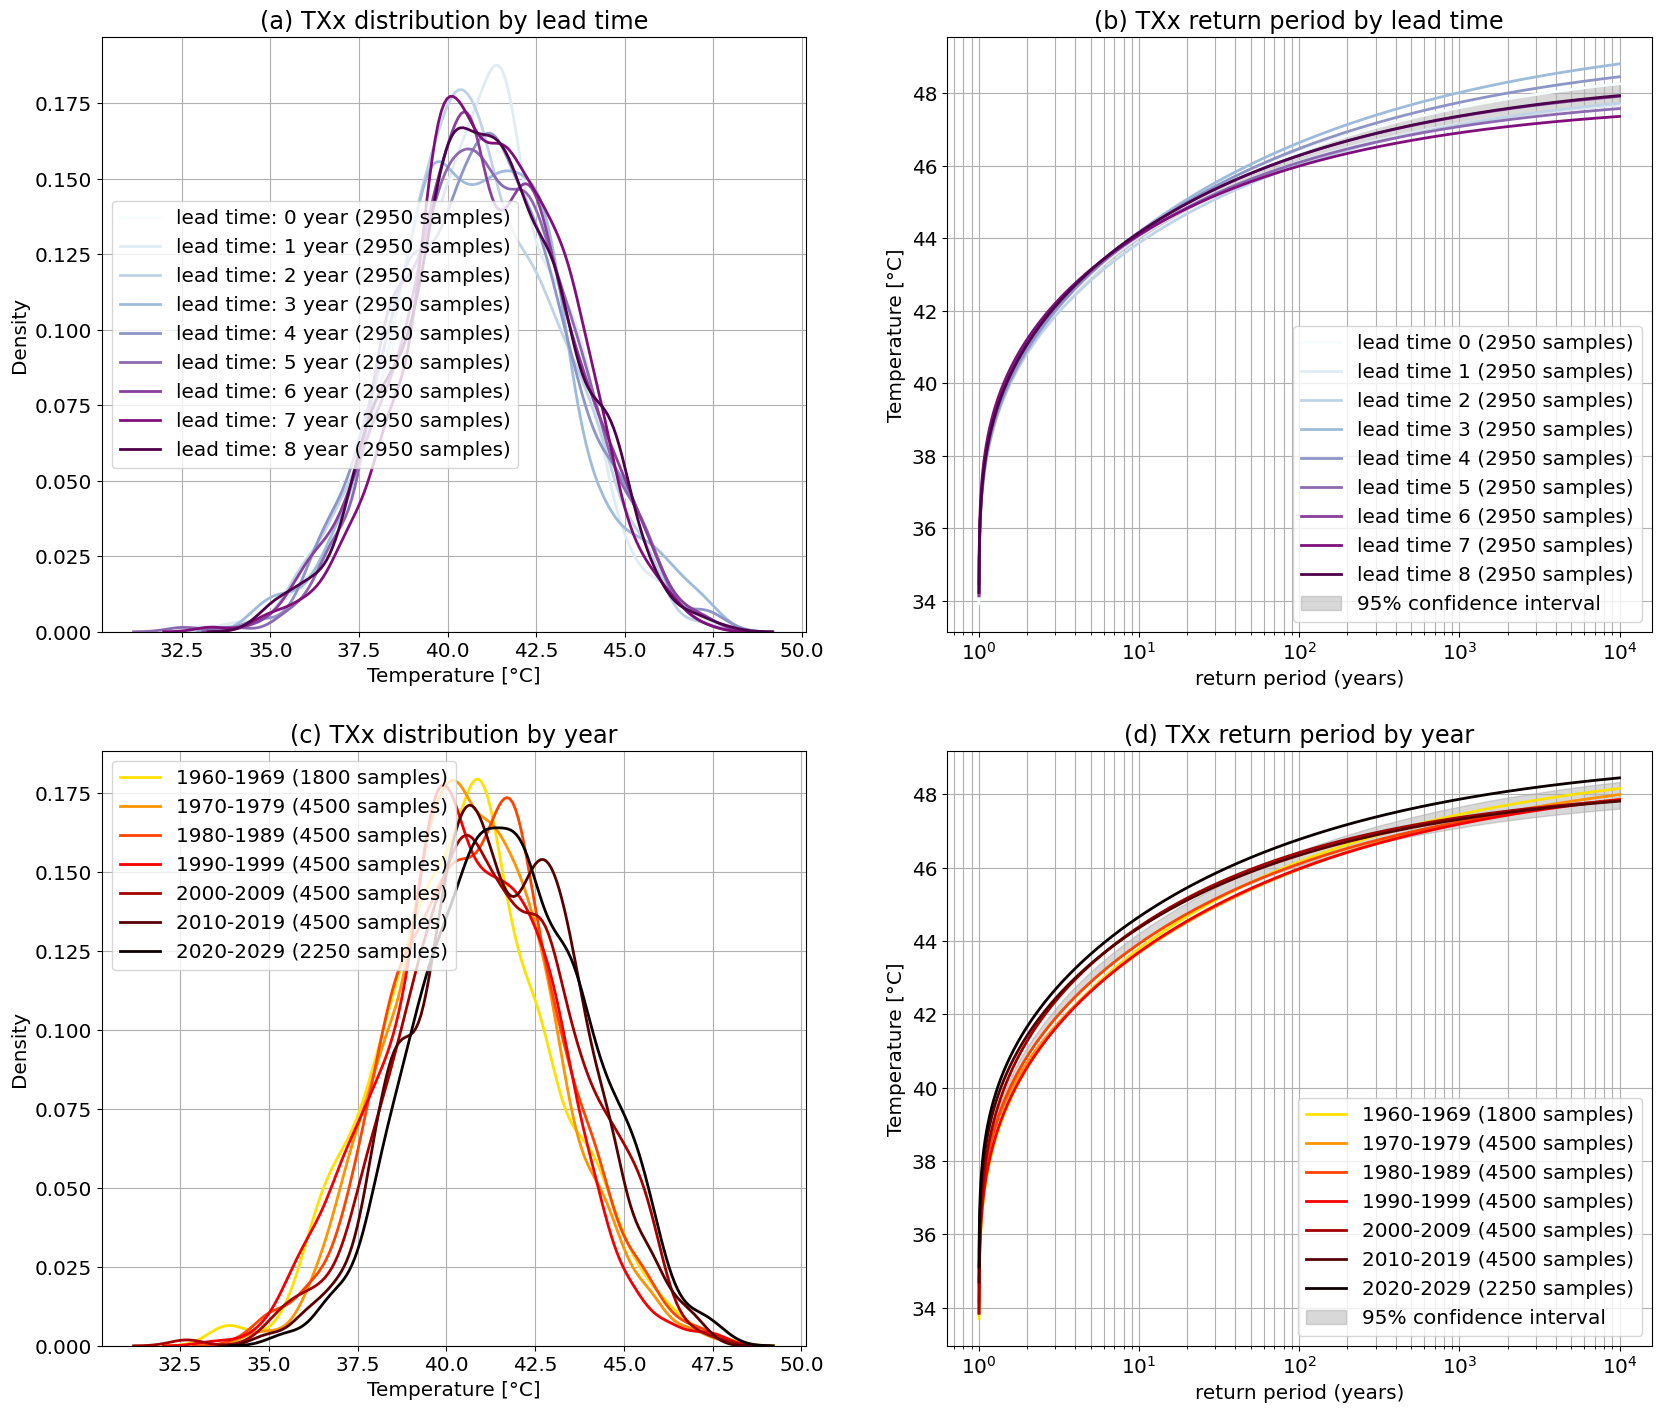

In [7]:
%%time

stability.create_plot(
    ds,
    index,
    [1960, 1970, 1980, 1990, 2000, 2010, 2020],
    uncertainty=True,
    return_method='gev',
    units='Temperature [°C]',
    outfile=f"{home}/figures/{index.lower()}_stability_{name.lower()}_{model}.png",
)


CPU times: user 14.7 s, sys: 199 ms, total: 14.9 s
Wall time: 15.3 s


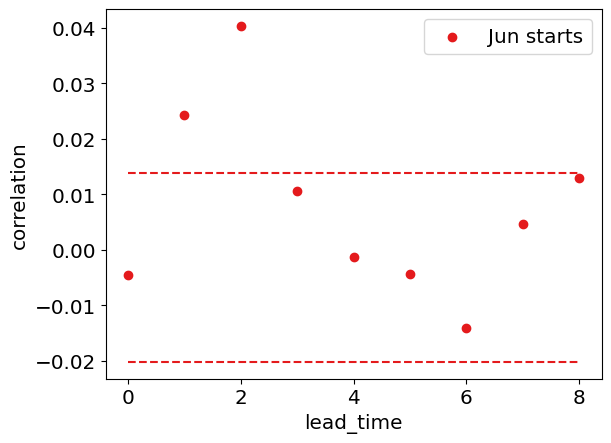

In [29]:
%%time

mean_correlations, null_correlation_bounds = independence.run_tests(ds)
independence.create_plot(
    mean_correlations,
    null_correlation_bounds, 
    f"{home}/figures/{index.lower()}_independence_{name.lower()}_{model}.png",
)

In [28]:
# Drop dependent lead times (drop if before the first lead_time within the bounds)
months = list(mean_correlations.keys())
assert len(months) == 1, "Multiple months, not implemented yet"
month = months[0]
mask = (mean_correlations[month] >= null_correlation_bounds[month][0]) & (
    mean_correlations[month] <= null_correlation_bounds[month][1]
)
min_lead_time = np.arange(mean_correlations[month].size)[mask].min()
print(min_lead_time)
da = ds.isel(lead_time=slice(min_lead_time, None), drop=True)
# da = ds.isel(lead_time=slice(1, None), drop=True)
da

0


<xarray.DataArray 'tasmax' (init_date: 295, ensemble: 10, lead_time: 9)> Size: 106kB
array([[[38.788727, 41.4494  , ..., 36.990753, 41.39261 ],
        [38.41327 , 38.816254, ..., 40.942657, 39.370056],
        ...,
        [40.852875, 43.767303, ..., 42.495636, 41.645477],
        [40.159332, 46.953583, ..., 39.61618 , 42.210052]],

       [[41.15222 , 42.711456, ..., 38.50284 , 40.327972],
        [40.52487 , 41.564728, ..., 38.561615, 40.06732 ],
        ...,
        [39.419952, 40.970734, ..., 39.52539 , 41.951447],
        [44.1463  , 40.191254, ..., 39.647705, 40.849823]],

       ...,

       [[41.31317 , 38.760376, ..., 44.17392 , 38.94052 ],
        [42.52713 , 38.565277, ..., 41.38849 , 41.765106],
        ...,
        [44.124603, 44.06717 , ..., 43.158417, 40.996094],
        [44.38498 , 40.67398 , ..., 46.51883 , 43.074615]],

       [[39.808075, 39.965363, ..., 40.841766, 40.50894 ],
        [41.409393, 39.39679 , ..., 39.263153, 41.24527 ],
        ...,
        [42.508453, 44.953644, ..., 40.97934 , 43.06845 ],
        [41.834686, 42.826965, ..., 40.68747 , 39.531097]]], dtype=float32)
Coordinates:
    event_time  (init_date, ensemble, lead_time) <U10 1MB ...
  * ensemble    (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 2kB 1962-06-30 00:00:00 ... 2020-06-30 00:...
    time        (lead_time, init_date) object 21kB ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-09-06T13:54:51Z altered by CMOR: Treated scalar dime...

In [30]:
# Drop AGCD years before model data is available
ds_obs = ds_obs.where(ds_obs.time.dt.year >= da.time.dt.year.min(), drop=True)
da_obs = ds_obs[var]

### Statistics

INFO:root:mean: Obs = 39.19050979614258, Model 95% CI =40.4172664642334 to 41.60858392715454
INFO:root:standard deviation: Obs = 2.187511920928955, Model 95% CI =1.9524618178606032 to 2.695221871137619
INFO:root:skew: Obs = 0.5495133683753488, Model 95% CI =-0.5173202614165646 to 0.45251540515553573
INFO:root:kurtosis: Obs = 0.0431305601483114, Model 95% CI =-0.8783822592175611 to 0.8534219798033862
INFO:root:GEV shape: Obs = 0.10207085098435249, Model 95% CI =0.13454358567450392 to 0.48107149856091996
INFO:root:GEV location: Obs = 38.25658595159936, Model 95% CI =39.56945070134308 to 40.87515518556419
INFO:root:GEV scale: Obs = 1.9074151175015979, Model 95% CI =1.8621313988114618 to 2.7853509109435484


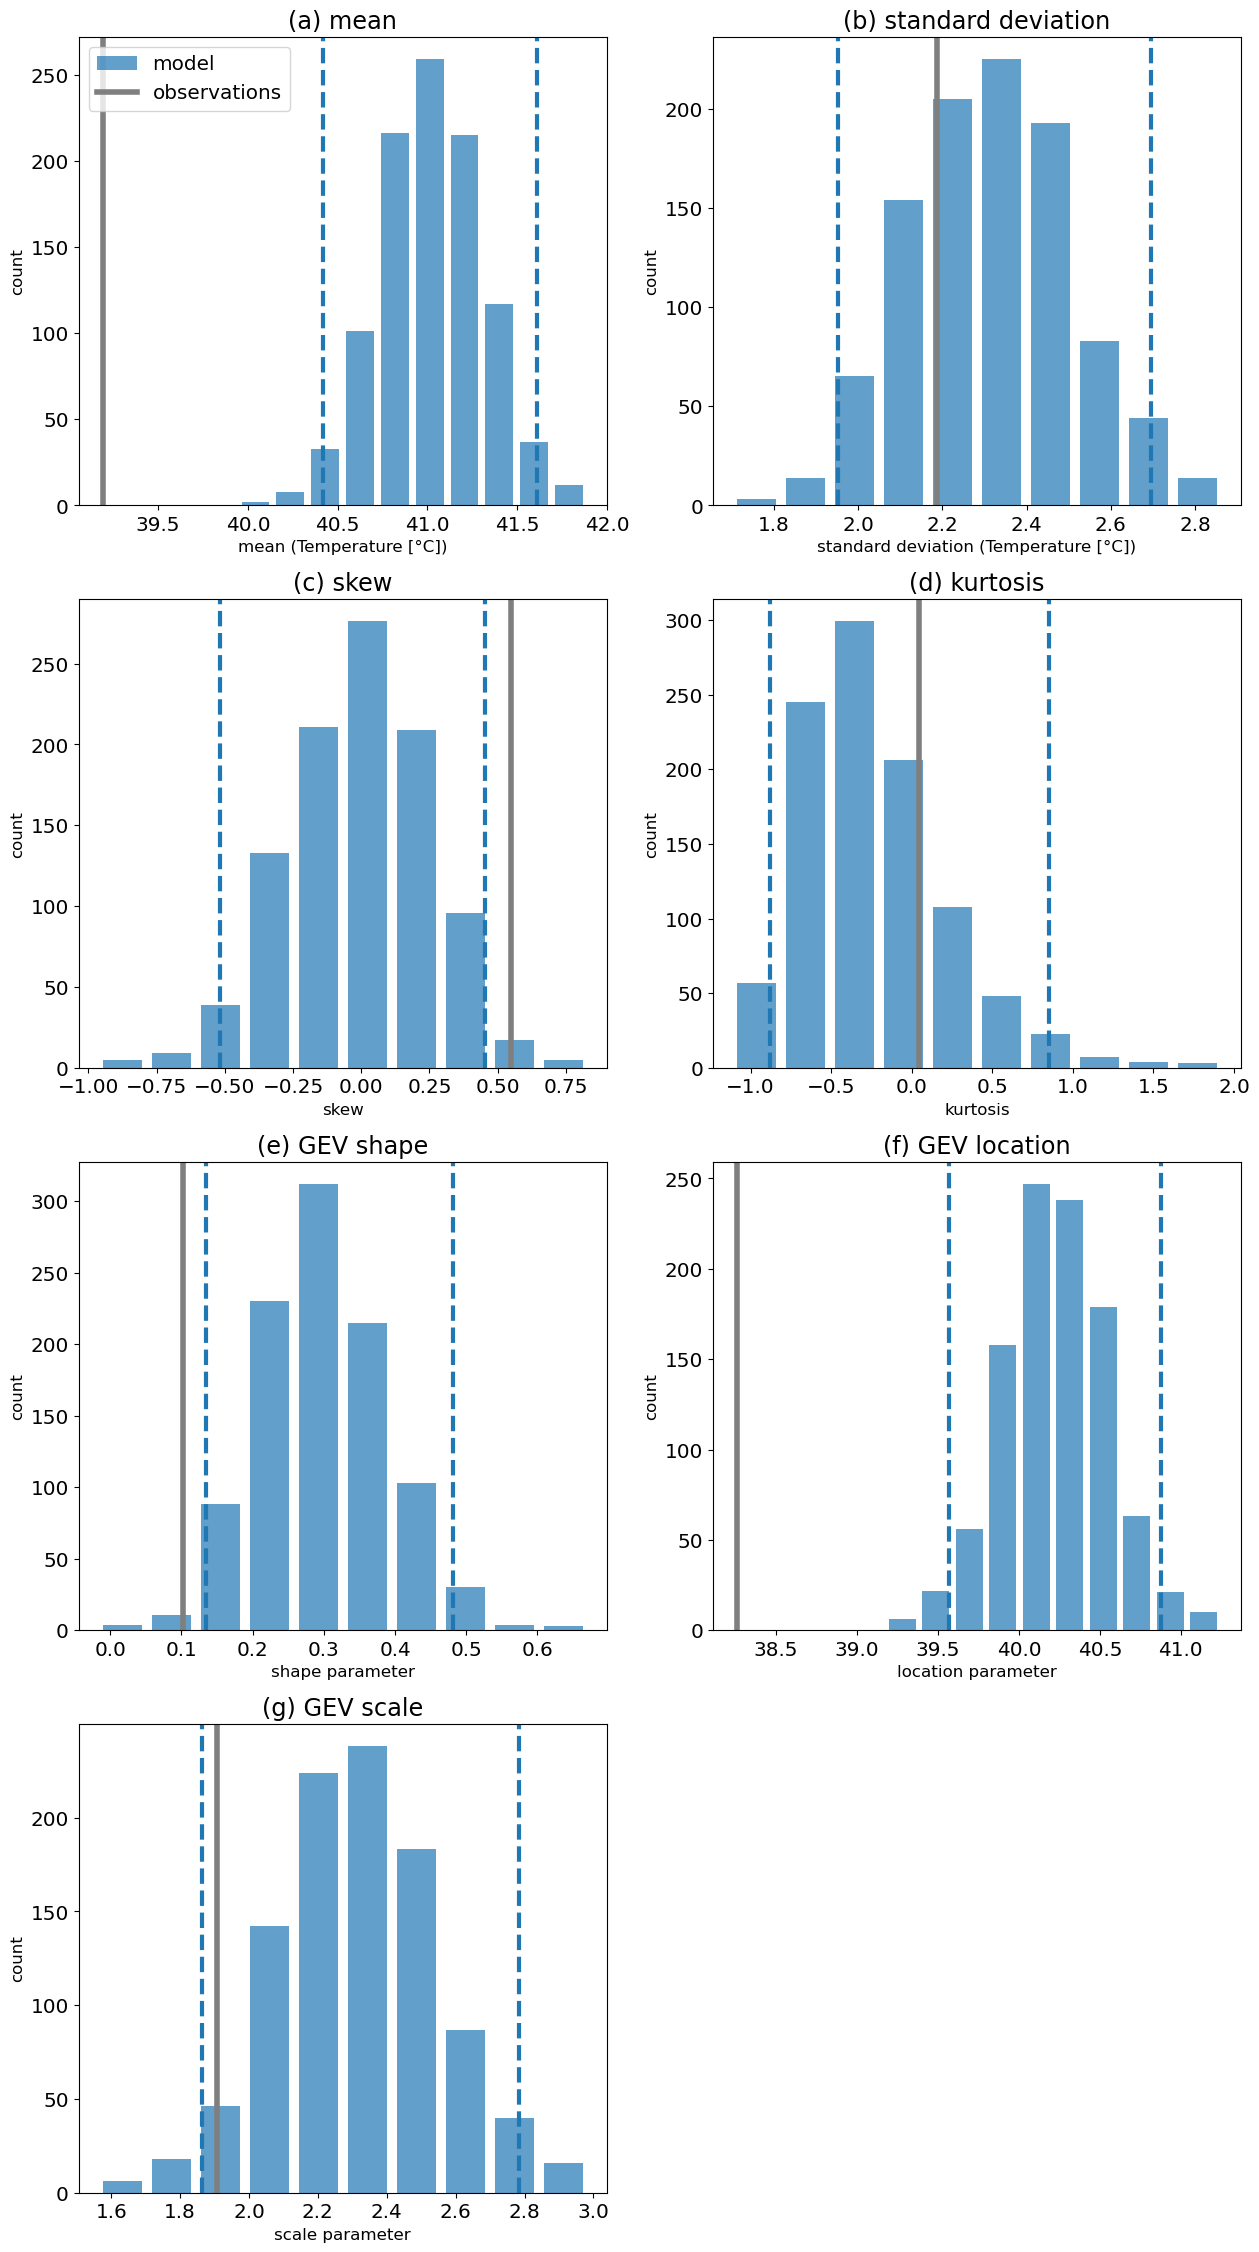

In [31]:
moments.create_plot(
    da,
    da_obs,
    da_bc_fcst=None,
    outfile=None,
    units=units,  # todo: change to deg C
    ensemble_dim="ensemble",
    init_dim="init_date",
    lead_dim="lead_time",
    infile_logs=None,
)

In [77]:
def get_event_seasonality(event_time, core_dim=[]):
    """Count the number of events each month."""
    months = np.arange(1, 13)

    def count_months(event_months):
        months_unique, month_counts = np.unique(event_months, return_counts=True)
        counts = np.zeros(12)
        counts[months_unique - 1] = month_counts
        return counts

    if event_time.dtype != "datetime64[ns]":
        event_time = event_time.astype("datetime64[ns]")

    event_months = event_time.dt.month
    counts = xr.apply_ufunc(
        count_months,
        event_months,
        input_core_dims=[[core_dim]],
        output_core_dims=[["month"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        dask_gufunc_kwargs=dict(output_sizes={"month": 12}),
    )

    return counts

### Seasonality

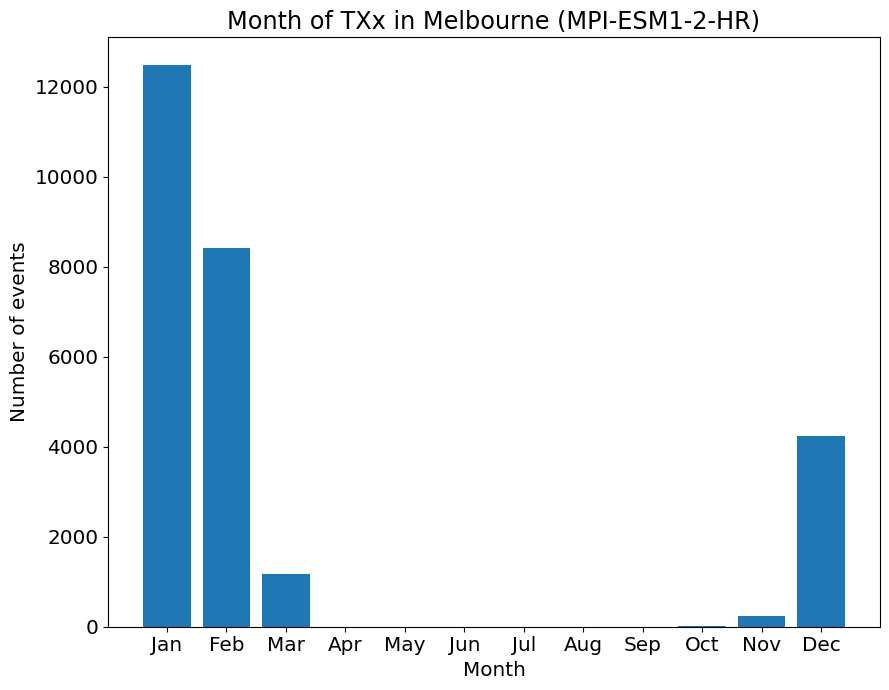

In [76]:
counts = get_event_seasonality(
    da.event_time.stack({"sample": ["ensemble", "init_date", "lead_time"]}),
    core_dim="sample",
)
months = np.arange(1, 13)


fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(months, counts)
# ax.hist(event_months, bins=np.arange(1, 14))
ax.set_title(f"Month of {index} in {name} ({model})")
ax.set_ylabel("Number of events")
ax.set_xlabel("Month")
xlabels = [calendar.month_abbr[i] for i in months]
ax.set_xticks(months, xlabels)
plt.tight_layout()
outfile = f"{home}/figures/{index.lower()}_month_model_{name.lower()}_AGCD.png"
plt.savefig(outfile, bbox_inches="tight", facecolor="white", dpi=200)

# Time series plots


In [ ]:
# Change time variables to years and stack model data
da.coords["time"] = da.time.dt.year
da["init_date"] = da.init_date.dt.year
da = da.stack({"sample": ["ensemble", "init_date", "lead_time"]})

mask = da_obs.time.dt.year > da.time.min()
da_obs = da_obs[mask]
da_obs.coords["time"] = da_obs.time.dt.year

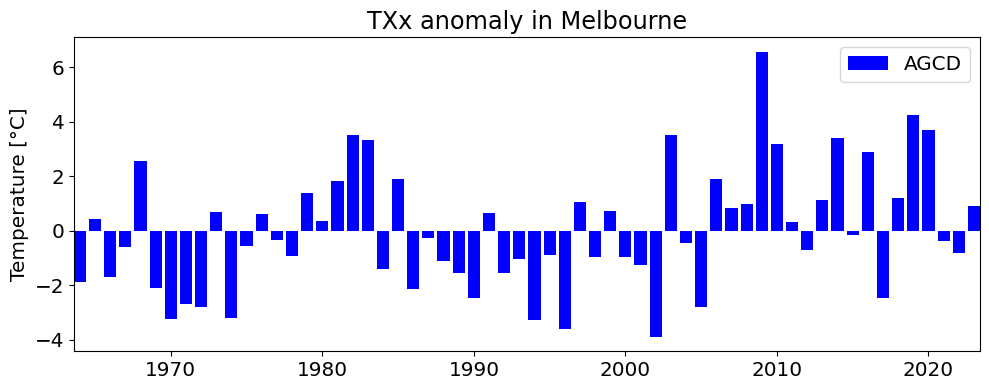

In [ ]:
# Plot AGCD anom time series
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"{index} anomaly in {name}")
ax.bar(da_obs.time, da_obs - da_obs.mean(), color="b", label="AGCD")
ax.set_xmargin(0)
ax.set_ylabel(units)
ax.legend()
plt.tight_layout()
plt.savefig(
    f"{home}/figures/{index.lower()}_timeseries_{name.lower()}_AGCD.png",
    dpi=200,
    bbox_inches="tight",
)

CPU times: user 1.13 s, sys: 17.6 ms, total: 1.14 s
Wall time: 1.17 s


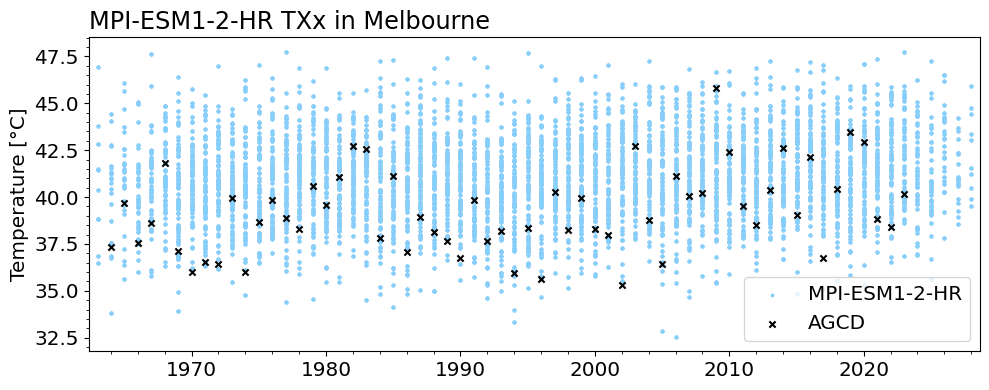

In [ ]:
%%time 

# AGCD & model time series (scatter)
ax = general_utils.plot_timeseries_scatter(
    da,
    da_obs,
    title=f"{model} {index} in {name}",
    label=model,
    obs_label='AGCD',
    units=units,
    time_dim="time",
    outfile=f"{home}/figures/{index.lower()}_timeseries_{name.lower()}_{model}.png",
)

CPU times: user 1.32 s, sys: 19.4 ms, total: 1.34 s
Wall time: 1.6 s


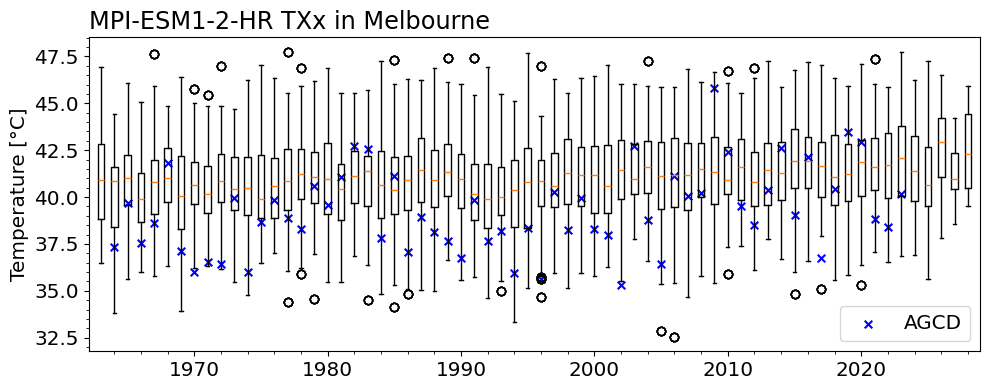

In [ ]:
%%time 
# Model box and whiskers time series
ax = general_utils.plot_timeseries_box_plot(
    da,
    da_obs,
    title=f"{model} {index} in {name}",
    label=model,
    obs_label='AGCD',
    units=units,
    time_dim="time",
    outfile=f"{home}/figures/{index.lower()}_timeseries_boxplot_{name.lower()}_{model}.png",
)


# Distribution parameters

## AGCD


In [ ]:
# Stationary parameters
theta_s_obs = eva.fit_gev(da_obs, stationary=True, core_dim="time")
theta_s_obs

array([ 0.08905715, 38.93402079,  1.87546382])

In [ ]:
# Nonstationary parameters
# todo: use similar data years to the model??
covariate_obs = da_obs.time.dt.year
theta_obs = eva.fit_gev(
    da_obs, covariate=covariate_obs, stationary=False, core_dim="time"
)
theta_obs = xr.DataArray(theta_obs, dims="theta")
theta_obs

<xarray.DataArray (theta: 5)> Size: 40B
array([ 1.50571665e-01, -1.74094491e+01,  2.83441090e-02,  2.58643000e-07,
        9.47631876e-04])
Dimensions without coordinates: theta

## Model


In [ ]:
# Stationary parameters
theta_s = eva.fit_gev(da, stationary=True, core_dim="sample")
theta_s

array([ 0.27006689, 40.13220821,  2.3417064 ])

In [ ]:
# Nonstationary parameters
covariate = da.time.dt.year
theta = eva.fit_gev(da, covariate=covariate, stationary=False, core_dim="sample")
theta = xr.DataArray(theta, dims="theta")
theta

<xarray.DataArray (theta: 5)> Size: 40B
array([ 2.66706873e-01,  7.93101163e+00,  1.61581874e-02,  2.80788200e+00,
       -2.42976756e-04])
Dimensions without coordinates: theta

### Plot nonstationary PDFs and return curves (for a subset of years)


In [ ]:
# Years to show
x = np.arange(covariate.min(), da_obs.time.dt.year.max())
x = x[:: x.size // 6]
x = xr.DataArray(x, dims="time")
print(x)

# x_obs = covariate_obs.values[::covariate_obs.size // x.size]
# x_obs = xr.DataArray(x_obs, dims='time')
# print(x_obs)

<xarray.DataArray (time: 7)> Size: 56B
array([1961, 1971, 1981, 1991, 2001, 2011, 2021])
Dimensions without coordinates: time


## Histogram and PDFs


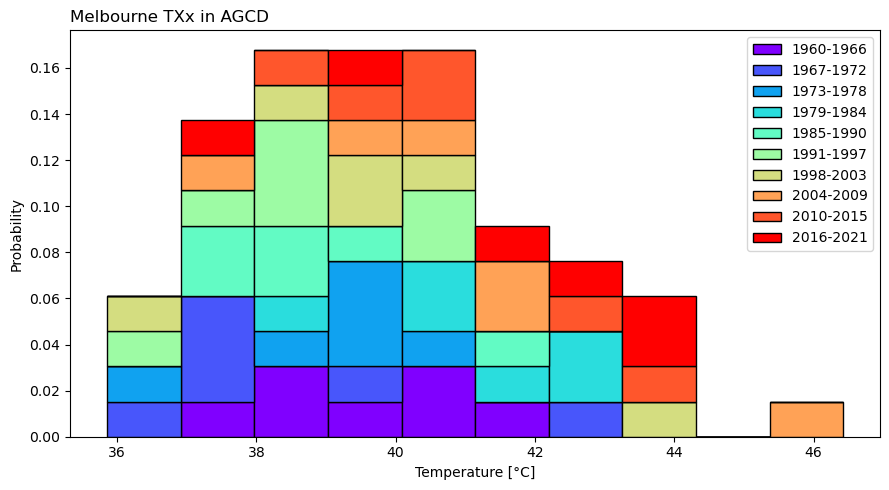

matplotlib.axes._axes.Axes

In [ ]:
# Stacked histogram
dv1 = da_obs.copy()
dv1.coords["time"] = dv1.time.dt.year.values.astype(dtype=int)
dim = "time"
dv2 = covariate_obs
bins = np.histogram_bin_edges(dv2)
bins = np.ceil(bins).astype(dtype=int)
labels = [f"{bins[i]}-{bins[i+1] - 1}" for i in range(len(bins) - 1)]

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax = eva.plot_stacked_histogram(ax, dv1, dv2, bins, labels, dim="time")
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
plt.tight_layout()
plt.show()

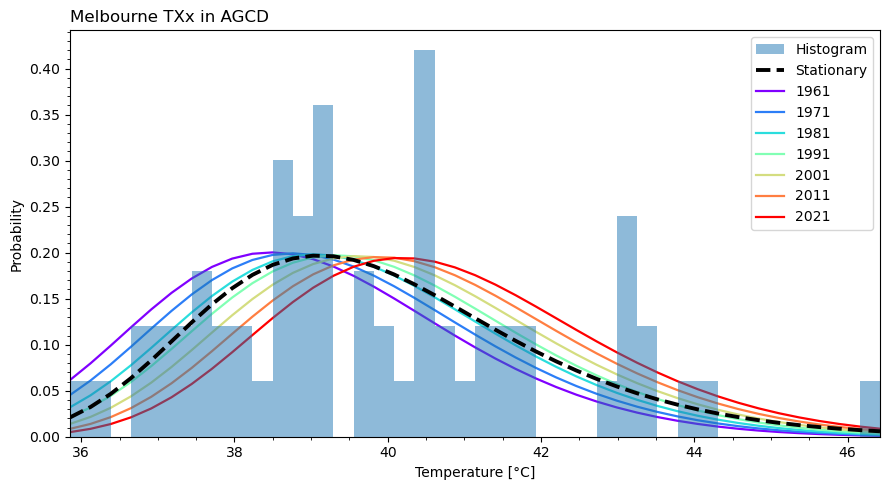

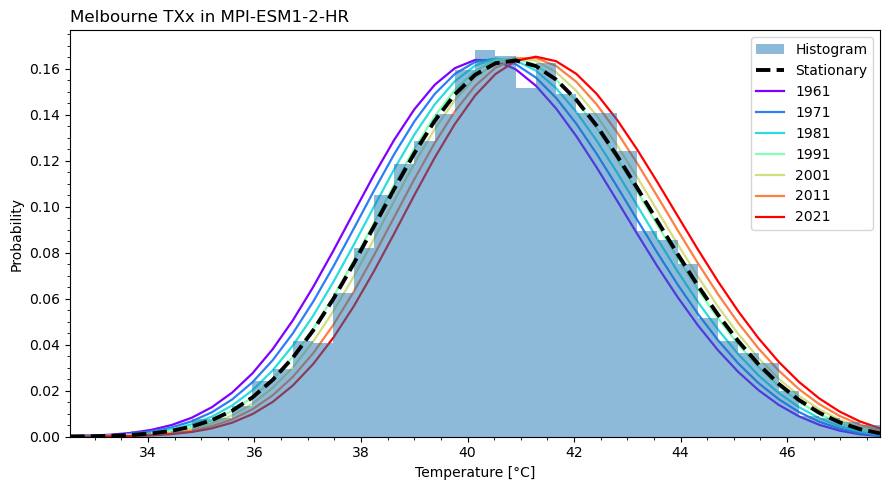

In [ ]:
# AGCD PDFs
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax = eva.plot_nonstationary_pdfs(ax, da_obs, theta_s_obs, theta_obs, x)
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(0)
plt.tight_layout()
plt.show()

# Model PDFs
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in {model}", loc="left")
ax = eva.plot_nonstationary_pdfs(ax, da, theta_s, theta, x)
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(0)
plt.tight_layout()
plt.show()

## Return curves


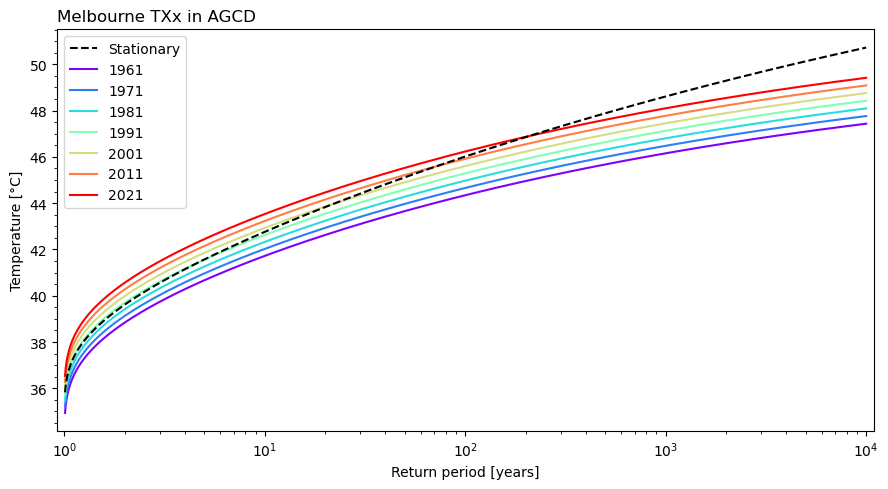

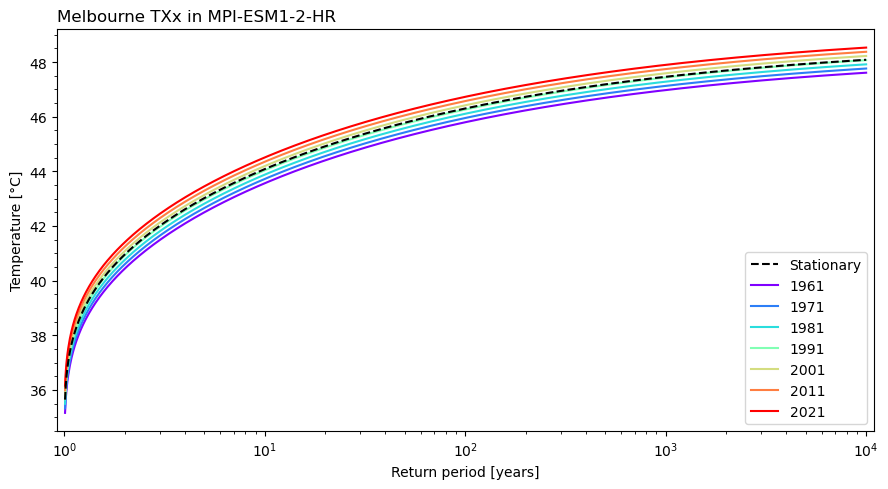

In [ ]:
return_periods = xr.DataArray(np.logspace(0, 4, num=1000), dims="rp")

# AGCD return curves
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax = eva.plot_nonstationary_return_curve(ax, return_periods, theta_s_obs, theta_obs, x)
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax.set_ylabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(1e-2)
plt.tight_layout()
plt.show()

# Model return curves
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax = eva.plot_nonstationary_return_curve(ax, return_periods, theta_s, theta, x)
ax.set_title(f"{name} TXx in {model}", loc="left")
ax.set_ylabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(1e-2)
plt.tight_layout()
plt.show()